In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow.keras.callbacks as cb
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
# matplotlib.use("Agg")
print(f"tf version: {tf.__version__}")

tf version: 2.2.0-rc3


In [3]:
"""
try:
  device_name = os.environ['COLAB_TPU_ADDR']
  TPU_ADDRESS = 'grpc://' + device_name
  print('Found TPU at: {}'.format(TPU_ADDRESS))

except KeyError:
  print('TPU not found')

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)
"""
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
class LossHistory(cb.Callback):
    def on_train_begin(self, logs=None):
        self.losses = []

    def on_batch_end(self, batch, logs=None):
        self.losses.append(logs.get('loss'))


In [0]:
# Resized images are now tf.float16, need to be cast back to uint8 for displaying
def resize_images(img):
    return tf.cast(tf.image.resize(img, [250, 400]), dtype=tf.float16)

In [0]:
def data_generator(data, batch_size, label_binarizer, mode='train', aug=None):
    while True:
        # Store images and labels for current batch
        images = []
        labels = []

        index = 0
        # Create batch
        while len(images) < batch_size:
            # If reach end of data, loop back to beginning
            if index == len(data):
                index = 0
                # If we are evaluating, don't want infinite data so stop when end of data is reached
                if mode == 'eval':
                    break

            # Get image and label and append to batch
            images.append(resize_images(data[index]['image']))
            labels.append(data[index]['label'])

        # One-hot encode labels
        labels = label_binarizer.transform(labels)

        # Apply data augmentation if aug is provided
        if aug is not None:
            (images, labels) = next(aug.flow(np.array(images), labels, batch_size=batch_size))

        # yield the batch
        yield (np.array(images), labels)

In [0]:
def create_model(mode):
  _model = None
  if mode == "none":
    _model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=IMAGE_SIZE),
      tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
      tf.keras.layers.Dropout(rate=0.25),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(units=256, activation='relu'),
      tf.keras.layers.Dropout(rate=0.5),
      tf.keras.layers.Dense(units=NUM_CLASSES, activation='softmax')
    ])
  else:
    # Classification layers at very top of network
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    dense_layer = tf.keras.layers.Dense(units=256, activation='relu')
    dropout = tf.keras.layers.Dropout(rate=0.5)
    prediction_layer = tf.keras.layers.Dense(units=196, activation='softmax')

    pretrained = None
    if mode == "xception":
        pretrained = tf.keras.applications.xception.Xception(include_top=False, weights='imagenet', input_shape=IMAGE_SIZE)
    elif mode == "vgg19":
      pretrained = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=IMAGE_SIZE)
    elif mode == "resnet50v2":
      pretrained = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False, weights='imagenet', input_shape=IMAGE_SIZE)
    elif mode == "inceptionv3":
      pretrained = tf.keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=IMAGE_SIZE)
    elif mode == "mobilenetv2":
      pretrained = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SIZE, include_top=False, weights='imagenet')
    elif mode == "densenet201":
      pretrained = tf.keras.applications.densenet.DenseNet201(include_top=False, weights='imagenet', input_shape=IMAGE_SIZE)
    elif mode == "nasnetlarge":
      pretrained = tf.keras.applications.nasnet.NASNetLarge(input_shape=IMAGE_SIZE, include_top=False, weights='imagenet')
  
    pretrained.trainable = False
    _model = tf.keras.Sequential([
      pretrained,
      global_average_layer,
      dense_layer,
      dropout,
      prediction_layer
    ])

  _model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return _model

In [0]:
ds, info = tfds.load(name='cars196', with_info=True, as_supervised=True, try_gcs=True)
ds_train, ds_test = ds['train'], ds['test']
data_labels = info.features['label'].names

IMAGE_SIZE = (160, 160, 3)
BATCH_SIZE = 32
NUM_CLASSES = 196
NUM_TRAIN = 8144
NUM_EPOCHS = 20

In [0]:
def get_dataset(train, test, batch_size=32):
  label_nums = np.linspace(1, NUM_CLASSES, NUM_CLASSES)
  depth = NUM_CLASSES
  encodings = tf.one_hot(label_nums, depth)

  def scale(image, label):
    image = tf.cast(tf.image.resize(image, [IMAGE_SIZE[0], IMAGE_SIZE[1]]), tf.float32)
    image /= 255.0
    label = encodings[label]
    return image, label

  train_dataset = train.map(scale).shuffle(NUM_TRAIN).batch(batch_size).prefetch(10)
  test_dataset = test.map(scale).batch(batch_size).prefetch(10)

  return train_dataset, test_dataset, info

(160, 160, 3)


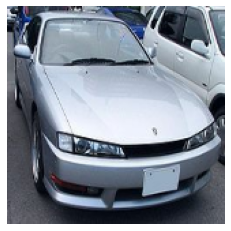

Label: 171 -> Plymouth Neon Coupe 1999
(160, 160, 3)


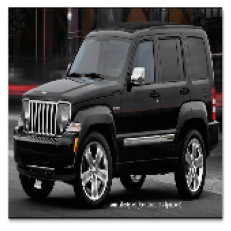

Label: 147 -> Jeep Grand Cherokee SUV 2012
(160, 160, 3)


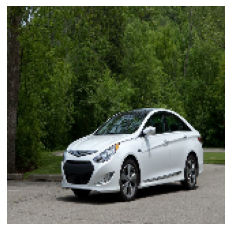

Label: 134 -> Hyundai Elantra Sedan 2007
(160, 160, 3)


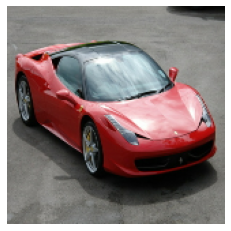

Label: 104 -> Fisker Karma Sedan 2012
(160, 160, 3)


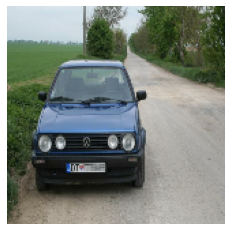

Label: 191 -> Volkswagen Beetle Hatchback 2012
(160, 160, 3)


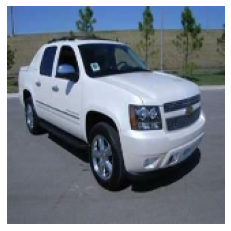

Label: 65 -> Chevrolet Cobalt SS 2010


In [13]:
train_dataset, test_dataset, info = get_dataset(ds_train, ds_test, batch_size=BATCH_SIZE)
for example in train_dataset.take(6):
    image, label = example[0], example[1]
    print(image[0].numpy().shape)
    plt.axis('off')
    plt.grid(b=None)
    plt.imshow(np.squeeze(image[0].numpy()))
    plt.show()
    print(f"Label: {np.argmax(label)} -> {data_labels[np.argmax(label)]}")

In [169]:
# Basic network, no pretrained base
model_basic = create_model("none")
print(model_basic.summary())

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 158, 158, 32)      896       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 156, 156, 64)      18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 78, 78, 64)        0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 78, 78, 64)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 389376)            0         
_________________________________________________________________
dense_43 (Dense)             (None, 256)               99680512  
_________________________________________________________________
dropout_24 (Dropout)         (None, 256)             

In [171]:
H = model_basic.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
255/255 [==============================] - 33s 128ms/step - loss: 5.7667 - accuracy: 0.0063 - val_loss: 5.2497 - val_accuracy: 0.0085
Epoch 2/20
255/255 [==============================] - 40s 157ms/step - loss: 5.2493 - accuracy: 0.0079 - val_loss: 5.2347 - val_accuracy: 0.0102
Epoch 3/20
255/255 [==============================] - 32s 127ms/step - loss: 5.1450 - accuracy: 0.0171 - val_loss: 5.1691 - val_accuracy: 0.0134
Epoch 4/20
255/255 [==============================] - 32s 127ms/step - loss: 4.3812 - accuracy: 0.1099 - val_loss: 5.2054 - val_accuracy: 0.0192
Epoch 5/20
255/255 [==============================] - 32s 127ms/step - loss: 2.6743 - accuracy: 0.3918 - val_loss: 5.6501 - val_accuracy: 0.0174
Epoch 6/20
255/255 [==============================] - 32s 127ms/step - loss: 1.5462 - accuracy: 0.6255 - val_loss: 6.2221 - val_accuracy: 0.0175
Epoch 7/20
255/255 [==============================] - 32s 127ms/step - loss: 0.9921 - accuracy: 0.7518 - val_loss: 6.8180 - val_ac

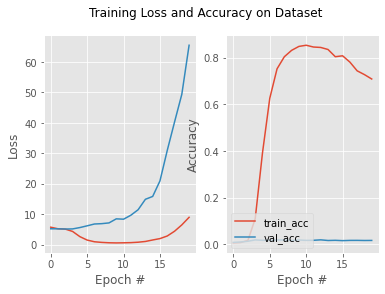

In [176]:
N = 20
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Training Loss and Accuracy on Dataset')
ax1.plot(np.arange(0, N), H.history["loss"], label="train_loss")
ax1.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
ax2.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
ax2.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
ax1.set(xlabel="Epoch #", ylabel="Loss")
ax2.set(xlabel="Epoch #", ylabel="Accuracy")
plt.legend(loc="lower left")

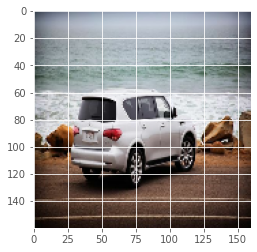

Label: (142, Isuzu Ascender SUV 2008), Prediction: (155, Lincoln Town Car Sedan 2011)


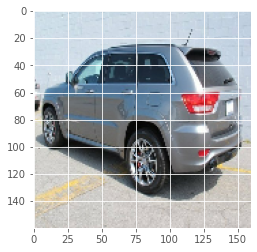

Label: (148, Jeep Compass SUV 2012), Prediction: (115, Ford E-Series Wagon Van 2012)


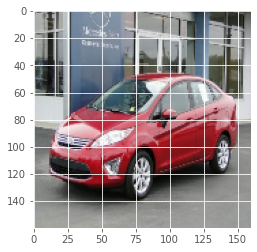

Label: (117, GMC Terrain SUV 2012), Prediction: (166, Mitsubishi Lancer Sedan 2012)


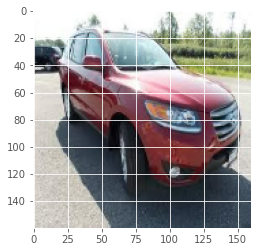

Label: (131, Hyundai Tucson SUV 2012), Prediction: (10, Aston Martin Virage Coupe 2012)


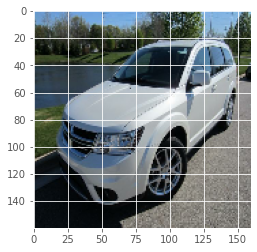

Label: (89, Dodge Dakota Crew Cab 2010), Prediction: (190, Volkswagen Golf Hatchback 1991)


In [47]:
data_labels = info.features['label'].names
predIdxs = model.predict(test_dataset)
predIdxs = np.argmax(predIdxs, axis=1)
# print(classification_report(testLabels.argmax(axis=1), predIdxs, target_names=lb.classes_))
index = 0
for example in test_dataset.take(5):
    image, label = example[0], example[1]
    plt.imshow(np.squeeze(image[0].numpy()))
    plt.show()
    #print(f"Label: {label} -> {data_labels[label]}")
    print(f"Label: ({np.argmax(label)}, {data_labels[np.argmax(label)]}), Prediction: ({predIdxs[index]}, {data_labels[predIdxs[index]]})")
    index += 1


In [179]:
# Xception pretrained network as base
model_xception = create_model("xception")
print(model_xception.summary())

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_21  (None, 2048)              0         
_________________________________________________________________
dense_47 (Dense)             (None, 256)               524544    
_________________________________________________________________
dropout_26 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 196)               50372     
Total params: 21,436,396
Trainable params: 574,916
Non-trainable params: 20,861,480
_________________________________________________________________
None


In [180]:
H = model_xception.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
255/255 [==============================] - 37s 143ms/step - loss: 4.9989 - accuracy: 0.0216 - val_loss: 4.5222 - val_accuracy: 0.0553
Epoch 2/20
255/255 [==============================] - 35s 139ms/step - loss: 4.5026 - accuracy: 0.0517 - val_loss: 4.1868 - val_accuracy: 0.0863
Epoch 3/20
255/255 [==============================] - 36s 142ms/step - loss: 4.2230 - accuracy: 0.0699 - val_loss: 3.9945 - val_accuracy: 0.1112
Epoch 4/20
255/255 [==============================] - 35s 139ms/step - loss: 4.0453 - accuracy: 0.0885 - val_loss: 3.8667 - val_accuracy: 0.1271
Epoch 5/20
255/255 [==============================] - 36s 142ms/step - loss: 3.9064 - accuracy: 0.1066 - val_loss: 3.7719 - val_accuracy: 0.1317
Epoch 6/20
255/255 [==============================] - 36s 141ms/step - loss: 3.7784 - accuracy: 0.1238 - val_loss: 3.7116 - val_accuracy: 0.1399
Epoch 7/20
255/255 [==============================] - 36s 140ms/step - loss: 3.6948 - accuracy: 0.1322 - val_loss: 3.6621 - val_ac

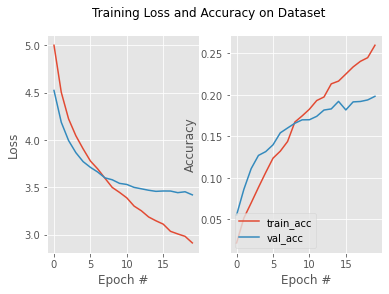

In [181]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Training Loss and Accuracy on Dataset')
ax1.plot(np.arange(0, N), H.history["loss"], label="train_loss")
ax1.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
ax2.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
ax2.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
ax1.set(xlabel="Epoch #", ylabel="Loss")
ax2.set(xlabel="Epoch #", ylabel="Accuracy")
plt.legend(loc="lower left")

In [182]:
# VGG19 pretrained network as base
model_vgg19 = create_model("vgg19")
print(model_vgg19.summary())

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 5, 5, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_22  (None, 512)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_27 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 196)               50372     
Total params: 20,206,084
Trainable params: 181,700
Non-trainable params: 20,024,384
_________________________________________________________________
None


In [183]:
H = model_vgg19.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
255/255 [==============================] - 39s 151ms/step - loss: 5.2758 - accuracy: 0.0048 - val_loss: 5.2376 - val_accuracy: 0.0078
Epoch 2/20
255/255 [==============================] - 38s 148ms/step - loss: 5.2195 - accuracy: 0.0080 - val_loss: 5.1724 - val_accuracy: 0.0142
Epoch 3/20
255/255 [==============================] - 38s 148ms/step - loss: 5.1333 - accuracy: 0.0133 - val_loss: 5.0513 - val_accuracy: 0.0228
Epoch 4/20
255/255 [==============================] - 38s 149ms/step - loss: 5.0200 - accuracy: 0.0196 - val_loss: 4.9338 - val_accuracy: 0.0338
Epoch 5/20
255/255 [==============================] - 37s 145ms/step - loss: 4.9276 - accuracy: 0.0244 - val_loss: 4.8250 - val_accuracy: 0.0366
Epoch 6/20
255/255 [==============================] - 38s 149ms/step - loss: 4.8355 - accuracy: 0.0291 - val_loss: 4.7410 - val_accuracy: 0.0502
Epoch 7/20
255/255 [==============================] - 37s 145ms/step - loss: 4.7652 - accuracy: 0.0319 - val_loss: 4.6488 - val_ac

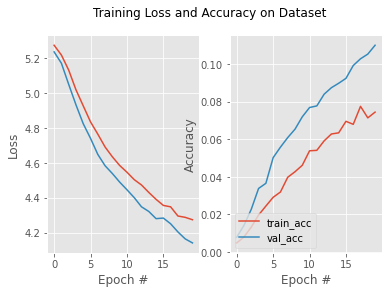

In [185]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Training Loss and Accuracy on Dataset')
ax1.plot(np.arange(0, N), H.history["loss"], label="train_loss")
ax1.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
ax2.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
ax2.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
ax1.set(xlabel="Epoch #", ylabel="Loss")
ax2.set(xlabel="Epoch #", ylabel="Accuracy")
plt.legend(loc="lower left")

In [19]:
# ResNet152v2 pretrained network as base
model_resnet50v2 = create_model("resnet50v2")
print(model_resnet50v2.summary())

94674944/94668760 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 5, 5, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 196)               50372     
Total params: 24,139,716
Trainable params: 574,916
Non-trainable params: 23,564,800
_________________________________________________________________
None


In [20]:
H = model_resnet50v2.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
255/255 [==============================] - 61s 239ms/step - loss: 5.0849 - accuracy: 0.0258 - val_loss: 4.6385 - val_accuracy: 0.0627
Epoch 2/20
255/255 [==============================] - 60s 233ms/step - loss: 4.5765 - accuracy: 0.0534 - val_loss: 4.2350 - val_accuracy: 0.0925
Epoch 3/20
255/255 [==============================] - 59s 233ms/step - loss: 4.2110 - accuracy: 0.0862 - val_loss: 3.9913 - val_accuracy: 0.1241
Epoch 4/20
255/255 [==============================] - 59s 232ms/step - loss: 3.9467 - accuracy: 0.1180 - val_loss: 3.8092 - val_accuracy: 0.1409
Epoch 5/20
255/255 [==============================] - 59s 232ms/step - loss: 3.7387 - accuracy: 0.1388 - val_loss: 3.7172 - val_accuracy: 0.1553
Epoch 6/20
255/255 [==============================] - 60s 235ms/step - loss: 3.5804 - accuracy: 0.1617 - val_loss: 3.6416 - val_accuracy: 0.1610
Epoch 7/20
255/255 [==============================] - 60s 237ms/step - loss: 3.4195 - accuracy: 0.1844 - val_loss: 3.5631 - val_ac

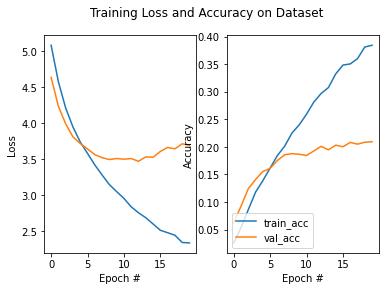

In [22]:
N = 20
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Training Loss and Accuracy on Dataset')
ax1.plot(np.arange(0, N), H.history["loss"], label="train_loss")
ax1.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
ax2.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
ax2.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
ax1.set(xlabel="Epoch #", ylabel="Loss")
ax2.set(xlabel="Epoch #", ylabel="Accuracy")
plt.legend(loc="lower left")

In [23]:
# InceptionV3 pretrained network as base
model_inceptionv3 = create_model("inceptionv3")
print(model_inceptionv3.summary())

87916544/87910968 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 196)               50372     
Total params: 22,377,700
Trainable params: 574,916
Non-trainable params: 21,802,784
_________________________________________________________________
None


In [24]:
H = model_inceptionv3.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
255/255 [==============================] - 58s 228ms/step - loss: 5.2702 - accuracy: 0.0085 - val_loss: 5.1449 - val_accuracy: 0.0136
Epoch 2/20
255/255 [==============================] - 57s 222ms/step - loss: 5.1116 - accuracy: 0.0108 - val_loss: 4.9282 - val_accuracy: 0.0172
Epoch 3/20
255/255 [==============================] - 56s 220ms/step - loss: 5.0110 - accuracy: 0.0113 - val_loss: 4.8219 - val_accuracy: 0.0194
Epoch 4/20
255/255 [==============================] - 57s 222ms/step - loss: 4.9844 - accuracy: 0.0115 - val_loss: 4.8093 - val_accuracy: 0.0204
Epoch 5/20
255/255 [==============================] - 55s 217ms/step - loss: 4.9563 - accuracy: 0.0098 - val_loss: 4.7644 - val_accuracy: 0.0261
Epoch 6/20
255/255 [==============================] - 55s 214ms/step - loss: 4.9252 - accuracy: 0.0117 - val_loss: 4.7483 - val_accuracy: 0.0281
Epoch 7/20
255/255 [==============================] - 54s 213ms/step - loss: 4.9205 - accuracy: 0.0158 - val_loss: 4.7391 - val_ac

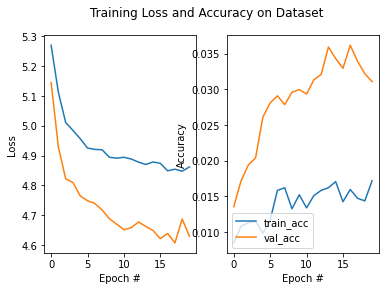

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Training Loss and Accuracy on Dataset')
ax1.plot(np.arange(0, N), H.history["loss"], label="train_loss")
ax1.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
ax2.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
ax2.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
ax1.set(xlabel="Epoch #", ylabel="Loss")
ax2.set(xlabel="Epoch #", ylabel="Accuracy")
plt.legend(loc="lower left")

In [26]:
# MobileNetv2 pretrained network as base
model_mobilenetv2 = create_model("mobilenetv2")
print(model_mobilenetv2.summary())

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               327936    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 196)               50372     
Total params: 2,636,292
Trainable params: 378,308
Non-trainable params: 2,257,984
_________________________________________________________________
None


In [27]:
H = model_mobilenetv2.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
255/255 [==============================] - 41s 161ms/step - loss: 4.9489 - accuracy: 0.0254 - val_loss: 4.2306 - val_accuracy: 0.0959
Epoch 2/20
255/255 [==============================] - 39s 153ms/step - loss: 4.1566 - accuracy: 0.0883 - val_loss: 3.7197 - val_accuracy: 0.1675
Epoch 3/20
255/255 [==============================] - 39s 153ms/step - loss: 3.6976 - accuracy: 0.1384 - val_loss: 3.3841 - val_accuracy: 0.2098
Epoch 4/20
255/255 [==============================] - 40s 157ms/step - loss: 3.3434 - accuracy: 0.1880 - val_loss: 3.2159 - val_accuracy: 0.2472
Epoch 5/20
255/255 [==============================] - 43s 168ms/step - loss: 3.0716 - accuracy: 0.2366 - val_loss: 3.0593 - val_accuracy: 0.2598
Epoch 6/20
255/255 [==============================] - 44s 172ms/step - loss: 2.8658 - accuracy: 0.2722 - val_loss: 2.9674 - val_accuracy: 0.2792
Epoch 7/20
255/255 [==============================] - 44s 173ms/step - loss: 2.6971 - accuracy: 0.3089 - val_loss: 2.9002 - val_ac

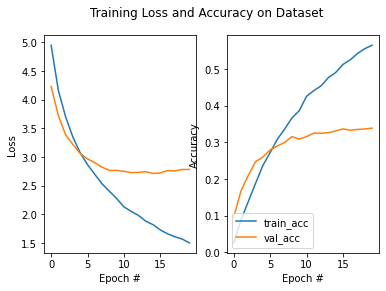

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Training Loss and Accuracy on Dataset')
ax1.plot(np.arange(0, N), H.history["loss"], label="train_loss")
ax1.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
ax2.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
ax2.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
ax1.set(xlabel="Epoch #", ylabel="Loss")
ax2.set(xlabel="Epoch #", ylabel="Accuracy")
plt.legend(loc="lower left")

In [0]:
# DenseNet201 pretrained network as base
model_densenet201 = create_model("densenet201")
print(model_densenet201.summary())

In [0]:
H = model_densenet201.fit(train_dataset, epochs=20, validation_data=test_dataset)

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Training Loss and Accuracy on Dataset')
ax1.plot(np.arange(0, N), H.history["loss"], label="train_loss")
ax1.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
ax2.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
ax2.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
ax1.set(xlabel="Epoch #", ylabel="Loss")
ax2.set(xlabel="Epoch #", ylabel="Accuracy")
plt.legend(loc="lower left")

In [0]:
# NasNetLarge pretrained network as base
model_nasnetlarge = create_model("nasnetlarge")
print(model_nasnetlarge.summary())

In [0]:
H = model_nasnetlarge.fit(train_dataset, epochs=20, validation_data=test_dataset)

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Training Loss and Accuracy on Dataset')
ax1.plot(np.arange(0, N), H.history["loss"], label="train_loss")
ax1.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
ax2.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
ax2.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
ax1.set(xlabel="Epoch #", ylabel="Loss")
ax2.set(xlabel="Epoch #", ylabel="Accuracy")
plt.legend(loc="lower left")